In [1]:
%matplotlib inline

import os, cv2
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

from dataset import *
from utils import *
from model import *
from train import *

2021-09-30 14:30:19.247066: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Data Exploration

## labels

In [2]:
train_labels = pd.read_csv ('../input/rsna-512x512-png/data/train_labels.csv')
train_labels = train_labels.drop (['Unnamed: 0'], axis = 1)
train_labels.sample (3)

,patientId,x,y,width,height,Target
23646,d4d2f79b-81a2-4d34-9abb-c68ad0b7c381,NaN,NaN,NaN,NaN,0
11779,798c347d-916a-45a6-8526-73f5b0552de6,NaN,NaN,NaN,NaN,0
11048,73cb75e6-0cef-4f7a-9c8d-cc9cc4eb0fd7,213.0,360.0,219.0,332.0,1


In [3]:
class_info = pd.read_csv ('../input/rsna-512x512-png/data/class_info.csv')
class_info = class_info.drop (['Unnamed: 0'], axis = 1)
class_info.sample (3)

,patientId,class
23384,d27b720c-e0fa-4257-a4c2-6d1c09a4750d,No Lung Opacity / Not Normal
7811,5a133587-a3b4-4515-be3e-fd0ee5a39f7a,No Lung Opacity / Not Normal
23134,d084e093-1b8c-4478-811e-f1d337cbeb2c,No Lung Opacity / Not Normal


## data analysis

In [4]:
# count_missing_data
train_labels.isnull ().sum ().sort_values (ascending = False)

x            20672
y            20672
width        20672
height       20672
patientId        0
Target           0
dtype: int64

In [5]:
class_info.isnull().sum().sort_values(ascending = False)

patientId    0
class        0
dtype: int64

In [6]:
count = class_info ["class"].value_counts()
count

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

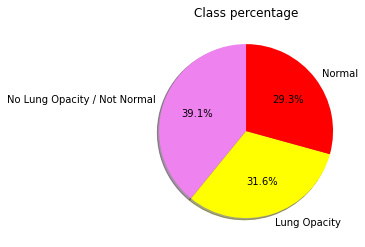

In [7]:
labels = (np.array(count.index))
sizes = (np.array((count / count.sum())*100))
colors = ['violet', 'yellow','red']

plt.pie(sizes, labels = labels, colors = colors,
        autopct = '%1.1f%%', shadow = True, startangle = 90)
plt.title("Class percentage")
plt.show ()

In [8]:
# merge class and labels
train_class = train_labels.merge (class_info, left_on = 'patientId', right_on = 'patientId', how = 'inner')
train_class.sample (3)

,patientId,x,y,width,height,Target,class
6961,42bfb1f3-9f7e-4e47-8983-49b16d73697f,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
10829,5ef82d3e-536f-4334-b0e3-81c03520ec1b,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
15813,80dd3324-cea6-47c3-bf7c-45a083f954a0,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [9]:
class_count = train_class.groupby ('Target')['class'].value_counts()
class_count

Target  class                       
0       No Lung Opacity / Not Normal    11821
        Normal                           8851
1       Lung Opacity                    16957
Name: class, dtype: int64

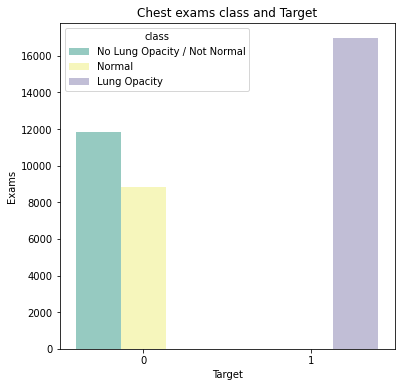

In [10]:
fig, ax = plt.subplots (nrows = 1, figsize = (6,6))
df = pd.DataFrame(data = {'Exams': class_count.values}, index = class_count.index).reset_index()
sns.barplot (ax = ax, x = 'Target', y = 'Exams', hue = 'class',data = df, palette = 'Set3')
plt.title ("Chest exams class and Target")
plt.show ()

## corellation

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


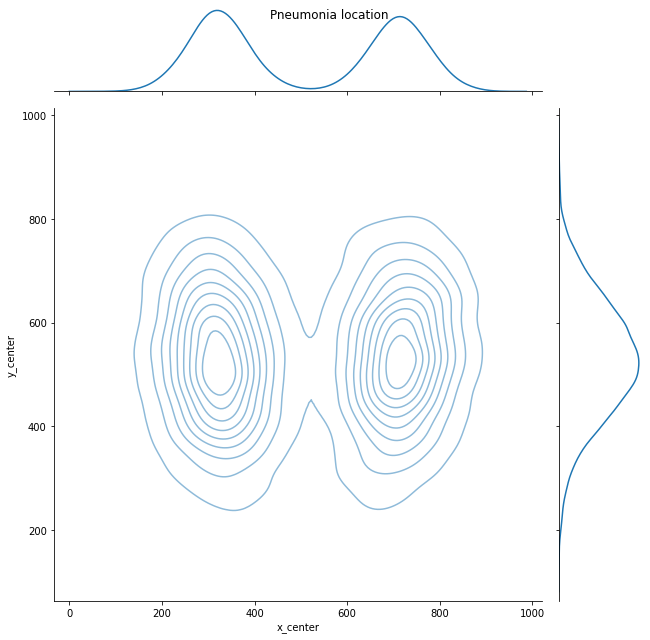

In [11]:
#Locating the penumonia location
# adding center in df
train_class  ['x_center'] = train_class ['x'] + train_class ['width'] / 2
train_class  ['y_center'] = train_class ['y'] + train_class ['height'] / 2
# Plot x and y centers
sns.jointplot ('x_center', 'y_center', kind = 'kde', data = train_class, height = 9, alpha = 0.5)
plt.suptitle ('Pneumonia location')
plt.show ()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


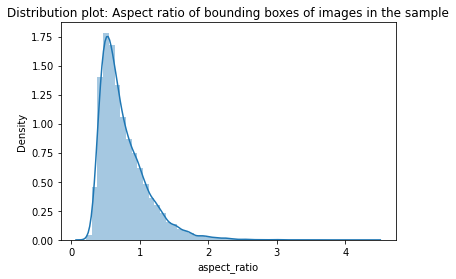

In [12]:
## Aspect ratio of bounding boxes in the sample
train_class ['aspect_ratio'] = train_class ['width'] / train_class ['height']
sns.distplot (train_class ['aspect_ratio'].dropna (), norm_hist=True)
plt.title ('Distribution plot: Aspect ratio of bounding boxes of images in the sample')
plt.show ()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


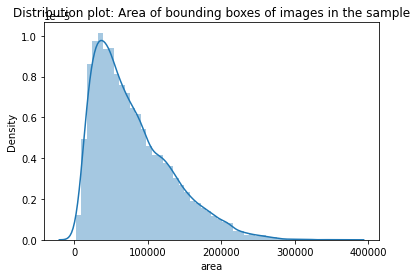

In [13]:
# Area of bounding boxes in the sample
train_class ['area'] = train_class ['width'] * train_class ['height']
sns.distplot (train_class ['area'].dropna (), norm_hist = True)
plt.title ('Distribution plot: Area of bounding boxes of images in the sample')
plt.show ()

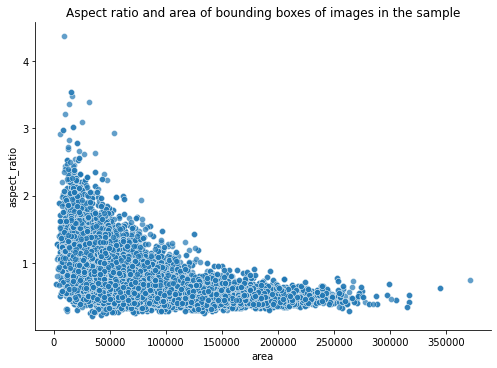

In [14]:
# Relationship between aspect ratio and area of bounding boxes of images in the sample
sns.relplot (x = 'area', y = 'aspect_ratio', data = train_class, height = 5, alpha = 0.7, aspect = 1.4)
plt.title ('Aspect ratio and area of bounding boxes of images in the sample')
plt.show ()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<Figure size 432x288 with 0 Axes>

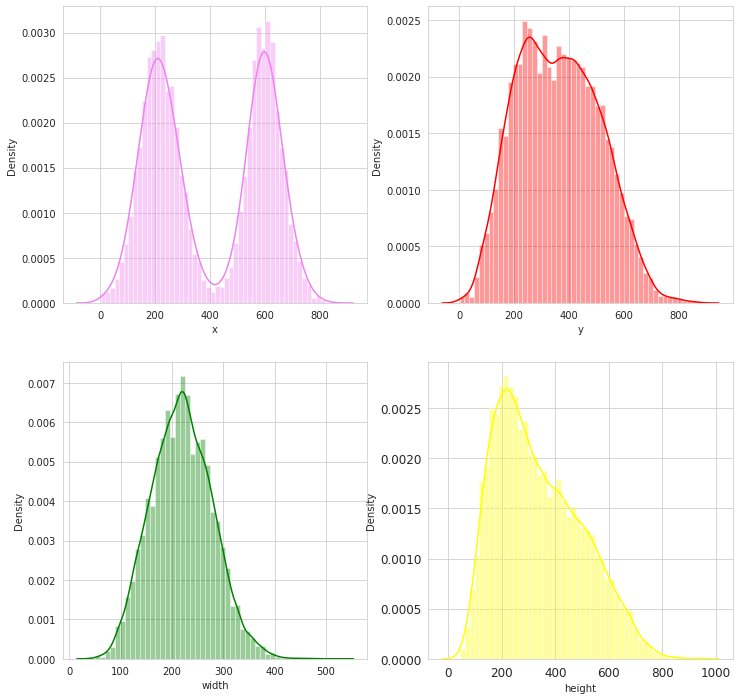

In [15]:
# For the class Lung Opacity, corresponding to values of Target = 1, we plot the density of x, y, width and height.
target1 = train_class [train_class ['Target'] == 1]
sns.set_style ('whitegrid')
plt.figure ()
fig, ax = plt.subplots (2, 2, figsize = (12, 12))
sns.distplot (target1 ['x'], kde = True, bins = 50, color = "violet", ax = ax [0,0])
sns.distplot (target1 ['y'], kde = True, bins = 50, color = "red", ax = ax[0,1])
sns.distplot (target1 ['width'], kde = True, bins = 50, color = "green", ax = ax [1,0])
sns.distplot (target1 ['height'], kde = True, bins = 50, color = "yellow", ax = ax [1,1])
locs, labels = plt.xticks ()
plt.tick_params (axis = 'both', which = 'major', labelsize = 12)
plt.show ()

## images

In [16]:
img_dir = '../input/rsna-512x512-png/data/stage_2_train_images'
print ('num images: ', len (os.listdir (img_dir)))

num images:  26684


In [17]:
# check for duplicate reconrds in training set
print("Unique patientId in  train_class: ", train_class ['patientId'].nunique())

Unique patientId in  train_class:  26684


In [18]:
train_class.shape

(37629, 11)

In [19]:
same_classes = train_class.groupby(['patientId','Target', 'class'])['patientId'].count()
same_classes

patientId                             Target  class                       
0004cfab-14fd-4e49-80ba-63a80b6bddd6  0       No Lung Opacity / Not Normal    1
000924cf-0f8d-42bd-9158-1af53881a557  0       Normal                          1
000db696-cf54-4385-b10b-6b16fbb3f985  1       Lung Opacity                    4
000fe35a-2649-43d4-b027-e67796d412e0  1       Lung Opacity                    4
001031d9-f904-4a23-b3e5-2c088acd19c6  1       Lung Opacity                    4
                                                                             ..
fffb2395-8edd-4954-8a89-ffe2fd329be3  1       Lung Opacity                    4
fffba05a-1635-4545-9bbd-57ad4cfe8d27  0       Normal                          1
fffc95b5-605b-4226-80ab-62caec682b22  0       No Lung Opacity / Not Normal    1
fffcff11-d018-4414-971a-a7cefa327795  0       No Lung Opacity / Not Normal    1
fffec09e-8a4a-48b1-b33e-ab4890ccd136  0       No Lung Opacity / Not Normal    1
Name: patientId, Length: 26684, dtype: int64

In [20]:
df = pd.DataFrame (data = {'Exams': same_classes.values}, index = same_classes.index).reset_index()
df.sample (3)

,patientId,Target,class,Exams
1527,15e6c264-0f5d-4659-805f-fddff71b48da,0,Normal,1
1497,15b84543-6888-481e-bdb1-f177de3d1f14,0,Normal,1
3933,3a0dc1e6-cfac-412d-a6c2-70c69236ee6a,0,Normal,1


In [21]:
tmp = df.groupby(['Exams','Target','class']).count()
tmp

patientId
Exams Target class                                  
1     0      No Lung Opacity / Not Normal      11821
             Normal                             8851
      1      Lung Opacity                       2614
4     1      Lung Opacity                       3266
9     1      Lung Opacity                        119
16    1      Lung Opacity                         13

In [22]:
df2 = pd.DataFrame (data = tmp.values, index = tmp.index).reset_index ()
df2.columns = ['Exams', 'Target','Class', 'Entries']
df2

,Exams,Target,Class,Entries
0,1,0,No Lung Opacity / Not Normal,11821
1,1,0,Normal,8851
2,1,1,Lung Opacity,2614
3,4,1,Lung Opacity,3266
4,9,1,Lung Opacity,119
5,16,1,Lung Opacity,13


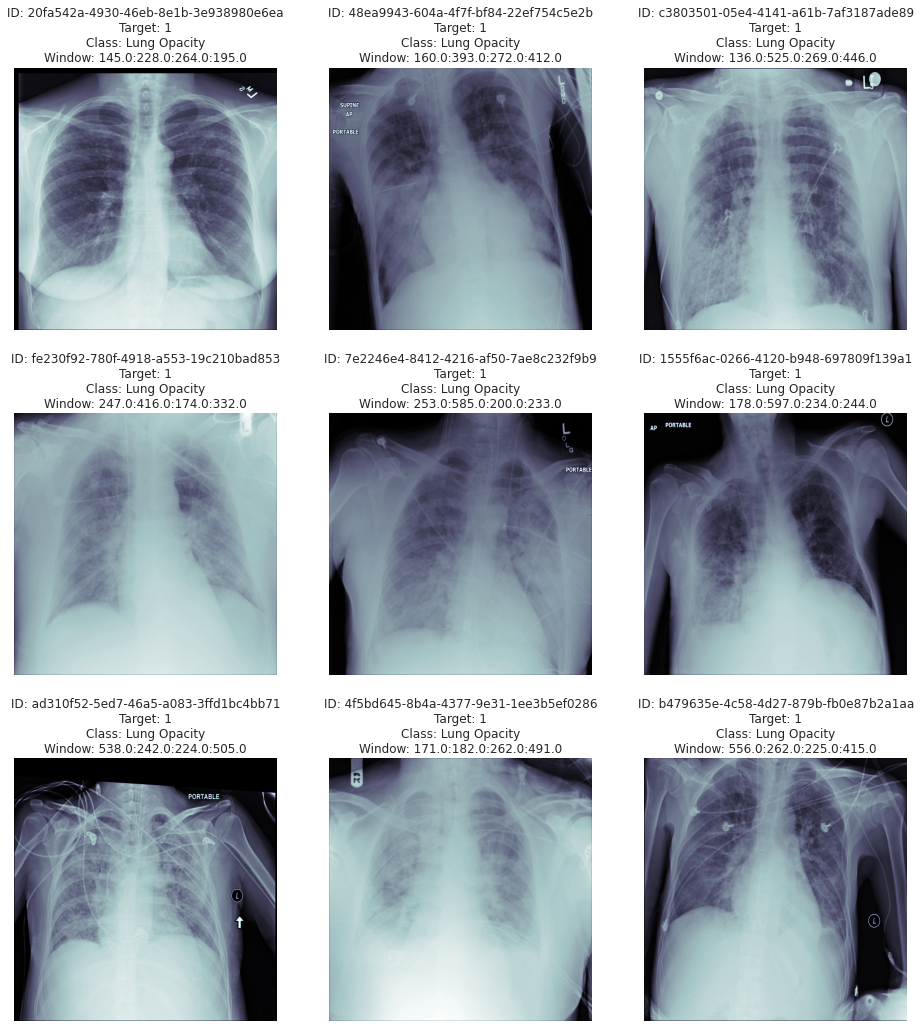

In [24]:
show_images (train_class [train_class ['Target'] == 1].sample (9))

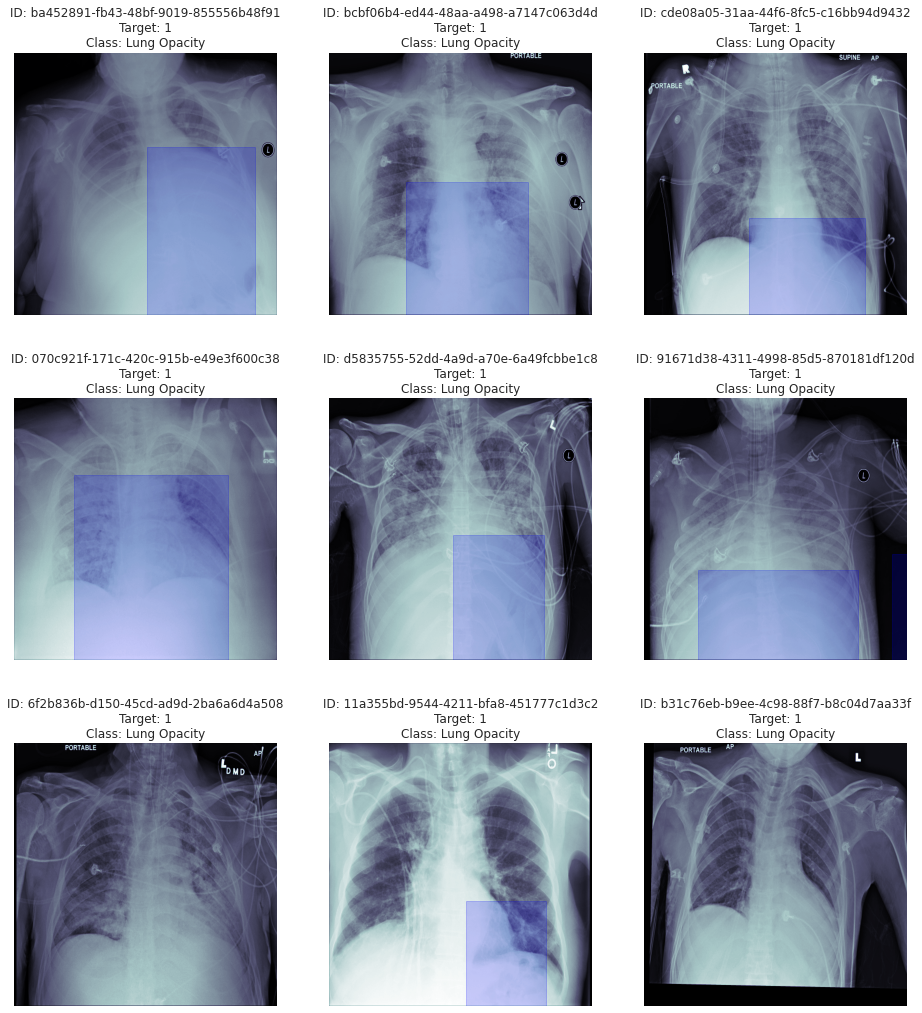

In [26]:
# bounding boxes are for 1024x1024 image but images are 512x512 => in training this problem will solve
show_images_with_bboxes (train_class [train_class ['Target'] == 1].sample (9))

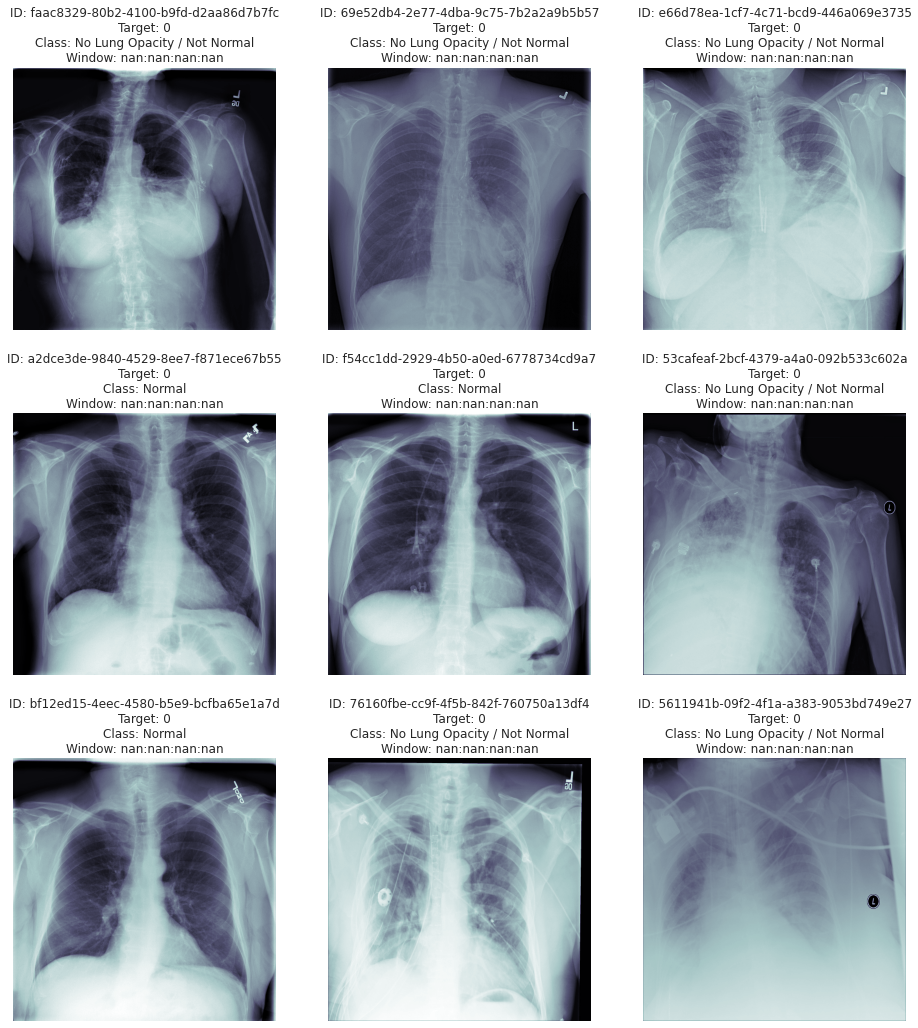

In [27]:
show_images (train_class [train_class ['Target'] == 0].sample (9))

# Build model & Dataset

In [28]:
pneumonia_locations = pneumonia_bboxes ('../input/rsna-512x512-png/data/train_labels.csv')

In [32]:
# load and shuffle filenames
filenames = os.listdir (img_dir)
random.shuffle (filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames [n_valid_samples:]
valid_filenames = filenames [:n_valid_samples]
print ('n train samples', len (train_filenames))
print ('n valid samples', len (valid_filenames))
n_train_samples = len (filenames) - n_valid_samples
print ('Total train images:', len (filenames))
print ('Images with pneumonia:', len (pneumonia_locations))

n train samples 24124
n valid samples 2560
Total train images: 26684
Images with pneumonia: 6012


In [36]:
# create network and compiler
model = create_network (input_size = 128, channels = 16, n_blocks = 2, depth = 3)
model.compile (optimizer = 'adam',
              loss = iou_bce_loss,
              metrics = ['accuracy', mean_iou])
print("model summary:", model.summary ())

learning_rate = tf.keras.callbacks.LearningRateScheduler (cosine_annealing)

2021-09-30 14:31:01.264958: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-30 14:31:01.268696: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-30 14:31:01.325271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 14:31:01.326332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-30 14:31:01.326424: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-30 14:31:01.362511: I tensorflow/stream_executor/platform/def

Add input shape: (None, 64, 64, 32)
Resnet block input shape: (None, 64, 64, 32)
Resnet block out shape: (None, 64, 64, 32)
concat block out shape: (None, 64, 64, 64)
mixed block out shape: (None, 64, 64, 32)
Add input shape: (None, 64, 64, 32)
Resnet block input shape: (None, 64, 64, 32)
Resnet block out shape: (None, 64, 64, 32)
concat block out shape: (None, 64, 64, 64)
mixed block out shape: (None, 64, 64, 32)
Add input shape: (None, 32, 32, 64)
Resnet block input shape: (None, 32, 32, 64)
Resnet block out shape: (None, 32, 32, 64)
concat block out shape: (None, 32, 32, 128)
mixed block out shape: (None, 32, 32, 64)
Add input shape: (None, 32, 32, 64)
Resnet block input shape: (None, 32, 32, 64)
Resnet block out shape: (None, 32, 32, 64)
concat block out shape: (None, 32, 32, 128)
mixed block out shape: (None, 32, 32, 64)
Add input shape: (None, 16, 16, 128)
Resnet block input shape: (None, 16, 16, 128)
Resnet block out shape: (None, 16, 16, 128)
concat block out shape: (None, 16, 

In [37]:
train_gen = generator (img_dir, train_filenames, pneumonia_locations,
                      batch_size = 16, image_size = 128, shuffle = False,
                      augment = True, predict = False)
valid_gen = generator (img_dir, valid_filenames, pneumonia_locations,
                      batch_size = 16, image_size = 128, shuffle = False,
                      predict = False)

In [38]:
callbacks = [
    ModelCheckpoint (filepath = 'RSNA_OD.h5', monitor = 'val_loss', save_best_only = True, verbose = 1),
    learning_rate
]

In [39]:
img, mask = next (iter (train_gen))
out = model (img)
print (img.shape)
print (mask.shape)
print (out.shape)

2021-09-30 14:31:07.287718: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-09-30 14:31:13.393717: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


(16, 128, 128, 1)
(16, 128, 128, 1)
(16, 128, 128, 1)


2021-09-30 14:31:14.432688: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


In [40]:
history = model.fit (train_gen, validation_data = valid_gen,
                     callbacks = callbacks, epochs = 5, shuffle = True)

2021-09-30 14:31:16.569378: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-30 14:31:16.574642: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/5
1507/1507 [==============================] - 3180s 2s/step - loss: 0.5017 - accuracy: 0.9597 - mean_iou: 0.5910 - val_loss: 0.4575 - val_accuracy: 0.9725 - val_mean_iou: 0.6993

Epoch 00001: val_loss improved from inf to 0.45753, saving model to RSNA_OD.h5
Epoch 2/5
1507/1507 [==============================] - 2955s 2s/step - loss: 0.4510 - accuracy: 0.9668 - mean_iou: 0.6712 - val_loss: 0.4353 - val_accuracy: 0.9646 - val_mean_iou: 0.6802

Epoch 00002: val_loss improved from 0.45753 to 0.43530, saving model to RSNA_OD.h5
Epoch 3/5
1507/1507 [==============================] - 2982s 2s/step - loss: 0.4365 - accuracy: 0.9685 - mean_iou: 0.6898 - val_loss: 0.4239 - val_accuracy: 0.9653 - val_mean_iou: 0.6957

Epoch 00003: val_loss improved from 0.43530 to 0.42389, saving model to RSNA_OD.h5
Epoch 4/5
1507/1507 [==============================] - 2999s 2s/step - loss: 0.4317 - accuracy: 0.9681 - mean_iou: 0.6883 - val_loss: 0.4893 - val_accuracy: 0.9746 - val_mean_iou: 0.7443

Epo

In [41]:
model.load_weights ('./RSNA_OD.h5')

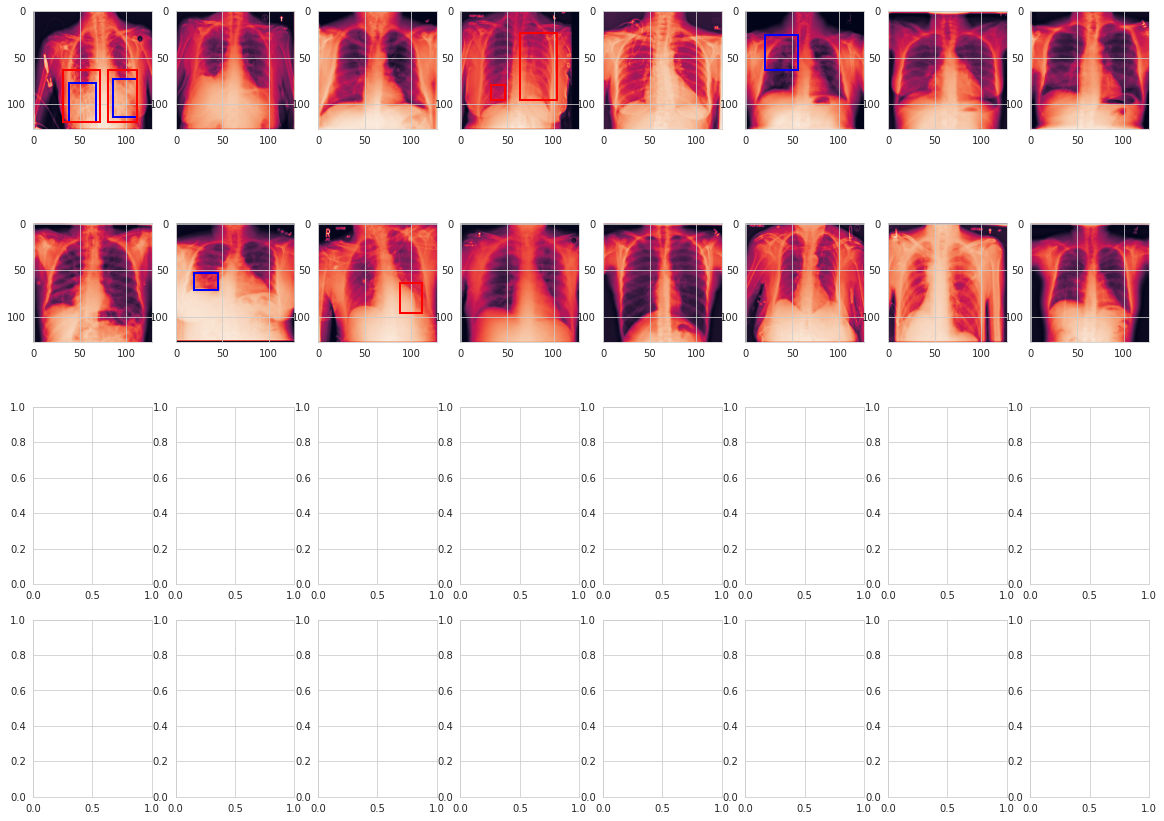

In [42]:
show_preds_with_bboxes (model, valid_dl)